# Application my nutriscore

## Recherche de produit par code barre

Maintenant que notre jeu de données a été nettoyé et rempli à l'aide d'algorithme de machine learning, nous souhaitons développer une application qui scanne un code barre d'un produit et affiche son nutriscore, si son nutriscore est manquant dans notre jeu de donnée, alors on calculera notre propre nutriscore basé sur une définition qu'on peut trouvé dans l'image ci-dessous.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import folium
from folium import plugins
from sklearn.impute import KNNImputer
from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram
import scipy.stats as sts

from IPython.display import Image

from sklearn import decomposition
from sklearn import preprocessing

import ipywidgets as widgets
from ipywidgets import interact, Layout,interactive, fixed

import missingno as msno

In [2]:
df = pd.read_csv('clean_OFF.csv', delimiter=',', low_memory=False)

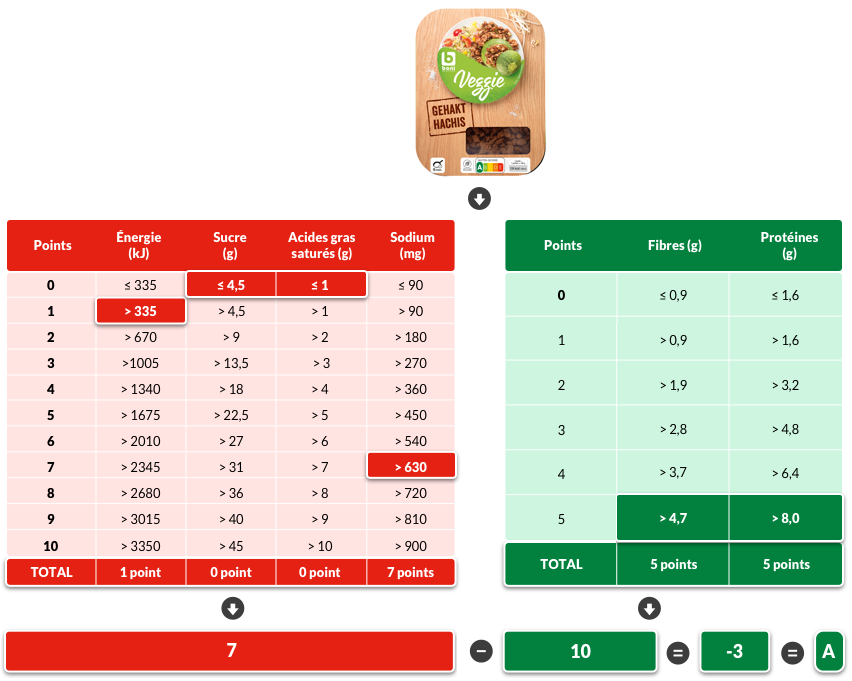

In [3]:
Image(filename='nutriscore/food-table-fr.png')

In [4]:
df.columns

Index(['Unnamed: 0', 'code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name', 'quantity',
       'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories',
       'categories_tags', 'categories_fr', 'countries', 'countries_tags',
       'countries_fr', 'ingredients_text', 'serving_size', 'additives_n',
       'additives', 'additives_tags', 'additives_fr',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr',
       'pnns_groups_1', 'pnns_groups_2', 'states', 'states_tags', 'states_fr',
       'main_category', 'main_category_fr', 'image_url', 'image_small_url',
       'energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g',
       'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'vitamin-a_100g',
       'vitamin-c_100g', 'calcium_100g', 'iron_100g',
       'nutrition-sc

In [5]:
df.code.unique()

array(['0000000024600', '0000000039259', '0000005200016', ...,
       '9906410000009', '99111250', '9935010000003'], dtype=object)

Cette application donnera à l'utlisateur, après avoir scanné un code barre d'un produit, le nutriscore relatif à ses valeurs nutritionnelles.

In [6]:
print(df[df['code']=='99111250']['product_name'])
print(df[df['code']=='99111250']['energy_100g'])
print(df[df['code']=='99111250']['sugars_100g'])
print(df[df['code']=='99111250']['saturated-fat_100g'])
print(df[df['code']=='99111250']['sodium_100g'])

62241    Thé vert Earl grey
Name: product_name, dtype: object
62241    21.0
Name: energy_100g, dtype: float64
62241    0.5
Name: sugars_100g, dtype: float64
62241    0.2
Name: saturated-fat_100g, dtype: float64
62241    0.01
Name: sodium_100g, dtype: float64


In [7]:
df[df['code']=='99111250']

,Unnamed: 0,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,...,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
62241,320763,99111250,http://world-fr.openfoodfacts.org/produit/9911...,balooval,1367163039,2013-04-28T15:30:39Z,1371690556,2013-06-20T01:09:16Z,Thé vert Earl grey,50 g,...,0.2,0.5,0.0254,0.01,NaN,NaN,NaN,NaN,2.0,0.0


In [8]:
df[df['code']=='99111250']['nutrition_grade_fr']

62241    c
Name: nutrition_grade_fr, dtype: object

Ce produit alimentaire "Thé vert Earl grey", a une note de nutriscore de C.

In [9]:
def my_nutriscore(code):
    my_product = df[df['code']==code]
    ##fruits_vegetable = [0.0,40.0,60.0,50.0,70.0,80.0]
    
    red = {'energy_100g' : [0.0,335.0,670.0,1005.0,1340.0,1675.0,2010.0,2345.0,2680.0,3015.0,3315.0],
           'sugars_100g' : [0.0,4.5,9.0,13.5,18.0,22.5,27.0,31.0,36.0,40.0,45.0],
           'saturated-fat_100g' : [0,1,2,3,4,5,6,7,8,9,10],
           'sodium_100g' : [0.0,0.090,0.180,0.270,0.360,0.450,0.540,0.630,0.720,0.810,0.900]
    }
    green = {
        'fiber_100g' : [0.0,0.9,1.9,2.8,3.7,4.7],
        'proteins_100g' : [0.0,1.6,3.2,4.8,6.4,8.0],
    }
        
    red_point = 0
    for i in red:
        for j in red[i]:
            if(my_product[i].values[0] >= j):
                k = red[i].index(j)
        red_point += k
    
    green_point = 0
    for i in green:
        for j in green[i]:
            if(my_product[i].values[0] >= j):
                k = green[i].index(j)
        green_point += k
    
    n = red_point - green_point

    if(n <= -1):
        return 'a'
    if(n > -1 and n <= 2):
        return 'b'
    if(n > 2 and n <= 10):
        return 'c'
    if(n > 10 and n <= 18):
        return 'd'
    if(n > 18):
        return 'e'

    return nutriscore

In [10]:
def my_nutriscore_2(val_nutri):
    
    red = {'energy_100g' : [0.0,335.0,670.0,1005.0,1340.0,1675.0,2010.0,2345.0,2680.0,3015.0,3315.0],
           'sugars_100g' : [0.0,4.5,9.0,13.5,18.0,22.5,27.0,31.0,36.0,40.0,45.0],
           'saturated-fat_100g' : [0,1,2,3,4,5,6,7,8,9,10],
           'sodium_100g' : [0.0,0.090,0.180,0.270,0.360,0.450,0.540,0.630,0.720,0.810,0.900]
    }
    green = {
        'fiber_100g' : [0.0,0.9,1.9,2.8,3.7,4.7],
        'proteins_100g' : [0.0,1.6,3.2,4.8,6.4,8.0],
    }
        
    red_point = 0
    for i in red:
        for j in red[i]:
            if(val_nutri[i] >= j):
                k = red[i].index(j)
        red_point += k
    
    green_point = 0
    for i in green:
        for j in green[i]:
            if(val_nutri[i] >= j):
                k = green[i].index(j)
        green_point += k
    
    n = red_point - green_point

    if(n <= -1):
        return 'a'
    if(n > -1 and n <= 2):
        return 'b'
    if(n > 2 and n <= 10):
        return 'c'
    if(n > 10 and n <= 18):
        return 'd'
    if(n > 18):
        return 'e'

    return nutriscore

In [11]:
def search(Code_Bar):
    n = df[df['code']==Code_Bar]

    if(n.empty != True):
        print(n.product_name.item())
        if(n.nutrition_grade_fr.values[0] in ['a','b','c','d','e']):
            print('Nutriscore obtenu du dataset :')
            display(Image(filename='nutriscore/'+n.nutrition_grade_fr.values[0]+'.png'))
        else:
            val_nutri = {'energy_100g':n.energy_100g.values[0],
                         'sugars_100g':n.sugars_100g.values[0],
                         'saturated-fat_100g':n['saturated-fat_100g'].values[0],
                         'sodium_100g':n.sodium_100g.values[0],
                         'fiber_100g':n.fiber_100g.values[0],
                         'proteins_100g':n.proteins_100g.values[0]}
            print('Nutriscore calculé :')
            display(Image(filename='nutriscore/'+my_nutriscore_2(val_nutri)+'.png'))
    else:
        print('Product does not exist')
        

#interact(search, Code_Bar="99111250")
interact(search, Code_Bar="9935010000003")

interactive(children=(Text(value='9935010000003', description='Code_Bar'), Output()), _dom_classes=('widget-in…

<function __main__.search(Code_Bar)>

## Aide à la creation d'aliment

In [12]:
def f(energy,sugars,saturated_fat,sodium,fiber,proteins):
    val_nutri = {'energy_100g':energy,
                 'sugars_100g':sugars,
                 'saturated-fat_100g':saturated_fat,
                 'sodium_100g':sodium,
                 'fiber_100g':fiber,
                 'proteins_100g':proteins}
    
    display(Image(filename='nutriscore/'+my_nutriscore_2(val_nutri)+'.png'))
    print()
    
interact(f, 
         #energy=widgets.IntSlider(min=0,max=3765,step=1,value=10,layout=Layout(width='1000px')),
         energy=widgets.widgets.BoundedIntText(min=0,max=3765,value=500),
         sugars=widgets.IntSlider(min=0,max=100,step=1,value=10,layout=Layout(width='500px')),
         saturated_fat=widgets.IntSlider(min=0,max=100,step=1,value=10,layout=Layout(width='500px')),
         sodium=widgets.IntSlider(min=0,max=100,step=1,value=10,layout=Layout(width='500px')),
         fiber=widgets.IntSlider(min=0,max=100,step=1,value=10,layout=Layout(width='500px')),
         proteins=widgets.IntSlider(min=0,max=100,step=1,value=10,layout=Layout(width='500px'))
        );


interactive(children=(BoundedIntText(value=500, description='energy', max=3765), IntSlider(value=10, descripti…

## Analyse bivariée 

In [13]:
df_noknn = pd.read_csv('clean_OFF_without_KNN.csv', delimiter=',', low_memory=False)

In [16]:
def analyse_bivariee(x):
    if(len(x) == 2):
        plt.plot(df[x[0]],df[x[1]],'o',alpha=0.5)
        plt.xlabel(x[0])
        plt.ylabel(x[1])
        plt.show()
        
        k = df.dropna()
        print(sts.pearsonr(k[x[0]],k[x[1]])[0])

interact(analyse_bivariee,
         x=widgets.SelectMultiple(description='Valeurs nutritionnelles',
                                  options=['fat_100g','energy_100g','carbohydrates_100g','sugars_100g','saturated-fat_100g','salt_100g','sodium_100g','fiber_100g','proteins_100g'],
                                  #selected_labels=selected
                                 ));

interactive(children=(SelectMultiple(description='Valeurs nutritionnelles', options=('fat_100g', 'energy_100g'…

[DOWNLOAD](http://localhost:8891/files/Desktop/Openclassroom/P3/PAGEWEB_2.ipynb?_xsrf=2%7Cef5db4ee%7C7ecce961be88e8cf13766069f7403e2c%7C1629382052)